- GITHUB:

    - git add *
    - git commit -m "escreve um comentário"
    - git push

In [359]:
import numpy as np
import matplotlib.pyplot as plt

In [360]:
import reservoirpy as rpy

rpy.set_seed(42) # Garante que reservatórios iniciem com mesmos pesos sempre

from reservoirpy.nodes import Reservoir

In [361]:
from sklearn.metrics import r2_score    

<img src="Estrutura_ESN.png" alt="estrutura_esn" width="800">

<img src="Nodo_ESN.png" alt="estrutura_esn" width="800">

$\dot{X}=\frac{1}{c}(-\alpha X + f(W^{in}u + WX + W^{fb}y ))$

$y = g(W^{out}[X;u])$

PARÂMETROS:

- *N*  : quantidade de neurônios no reservatório; 

- *lr* : o taxa vazante, que controla a constante de tempo dos neurônios;

    - Controla a dinâmica temporal do reservatório;
    - *lr* próximo de 1 o reservatório é totalmente atualizado;
    - *lr* próximo de 0 o reservatório nunca muda. 

- *sr* : o raio espectral das conexões recorrentes no reservatório. Controla a caoticidade da dinâmica do reservatório.

In [362]:
reservoir = Reservoir(100, lr=0.5, sr=0.9)

CRIANDO FUNÇÃO GERADORA

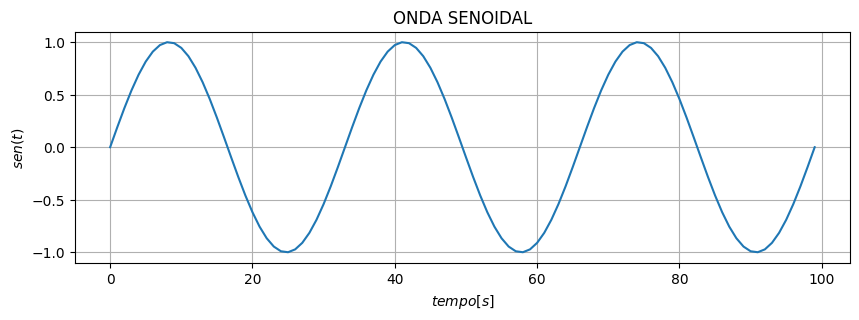

In [363]:
X = np.sin(np.linspace(0, 6*np.pi, 100)).reshape(-1, 1)

plt.figure(figsize=(10, 3))
plt.title("ONDA SENOIDAL")
plt.ylabel("$sen(t)$")
plt.xlabel("$tempo [s]$")
plt.grid()
plt.plot(X)
plt.show()

RESERVATÓRIO:

- Inicialmente reservatório está vazio;

- Para começar a usar o reservatório, pode-se apenas executá-lo com uma série temporal;

    - Necessário para inferir as dimensões de alguns parâmetros, tal qual a dimensão de entrada;

    - Dados de entrada *senoide*: (100,1);

    - Ativando o reservatório com apenas o primeiro dado da série temporal.

In [364]:
s = reservoir(X[0])
print("Vetor de Estados:", s.shape)

Vetor de Estados: (100,)


- Acionar um nó nos dados não só retorna as ativações desse nó, como também armazena essa ativação no estado interno do nó;

- Este estado pode ser acessado a qualquer momento no dicionário *state[ ]*;

- Inicializado com vetor nulo e atualizado toda vez que chamado o nó em algum dado.

In [365]:
s = reservoir.state["out"]

- Ao se realizar chamadas sucessivas ao reservatório, reune-se as ativações de toda série;

In [366]:
states = np.empty((len(X), reservoir.output_dim))
for i in range(len(X)):
    states[i] = reservoir(X[i])
print(states)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.09351187  0.          0.         ...  0.          0.
   0.        ]
 [-0.22991632 -0.01711405 -0.00832218 ...  0.          0.
   0.01874593]
 ...
 [ 0.44499851  0.23699005  0.20231775 ... -0.22867747 -0.0611724
  -0.40470889]
 [ 0.29703169  0.20297973  0.15768696 ... -0.23097589 -0.05461869
  -0.3791283 ]
 [ 0.12363611  0.15707945  0.10562644 ... -0.22772953 -0.04737063
  -0.33861351]]


- Resposta de 20 neurônios do reservatório para cada ponto da série temporal.

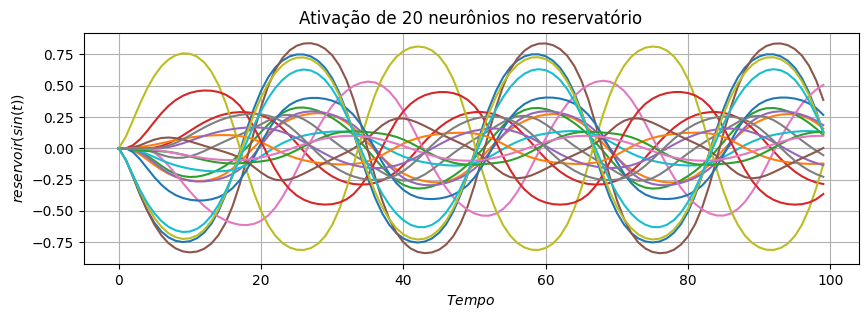

In [367]:
plt.figure(figsize=(10, 3))
plt.title("Ativação de 20 neurônios no reservatório")
plt.ylabel("$reservoir(sin(t))$")
plt.xlabel("$Tempo$")
plt.plot(states[:, :20])
plt.grid()
plt.show()

Outra Execução:

- As ativações do nó podem ser feitas sem usar o *looping* ;
- Pode-se apenas utilizar o **run( )** ;
- O número de neurônios no reservatório já foi dimensionado, basta informar a *timeseries* .

In [368]:
states = reservoir.run(X)
print(states.shape)

(100, 100)


- É possível também redefinir o reservatório para um vetor nulo .

In [369]:
_ = reservoir.reset()

# Criando Leitura

- A parametrização é realizada de maneira equivalente;

- *ridge = $1e^{-7}$* é um hiperparâmetro que ajuda a evitar overfitting ao conectar os nós;

- Não é necessário especificar o número de neurônios de saída com antecedência em uma leitura;

- Pode-se realizar isso no momento do treinamento.

In [370]:
from reservoirpy.nodes import Ridge

readout = Ridge(ridge=1e-7)

- Rotina de Treinamento ;

- A ideia é prever o valor do seno no tempo à frente **(t+1)** ;

- Seleção dos dados de treinamento;

- **X_train** são as primeiras 50 amostras. 

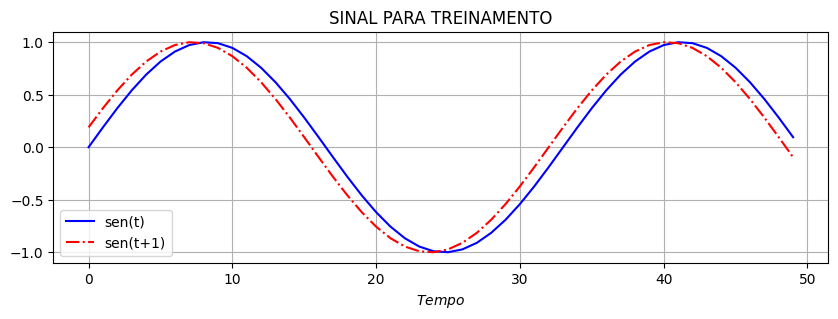

In [371]:
X_train = X[:50]
Y_train = X[1:51]

plt.figure(figsize=(10, 3))
plt.title("SINAL PARA TREINAMENTO")
plt.xlabel("$Tempo$")
plt.plot(X_train, label="sen(t)", color="blue", linestyle="-")
plt.plot(Y_train, label="sen(t+1)", color="red", linestyle="-.")
plt.grid()
plt.legend()
plt.show()

- Executando o reservatório com os dados de treinamento antes da leitura.

In [372]:
train_states = reservoir.run(X_train)

- Treinamento da leitura: **fit ( )** ;

- *warmup = 10* : Parâmetro para definir a quantidade de timesteps para descartar no início do *train_states* .

- Importante para que o reservatório entenda mais sobre a dinâmica da entrada.

In [373]:
readout = readout.fit(train_states, Y_train, warmup=10)

- Realizando o teste da ESN;

- *X_test* são os últimos 50 dados;

- Executa os estados do reservatório;

- Executar a leitura (pesquisar pq ter um ridge)

In [374]:
X_test = X[50:]
Y_test = X[51:]
test_states = reservoir.run(X_test)
Y_pred = readout.run(test_states)

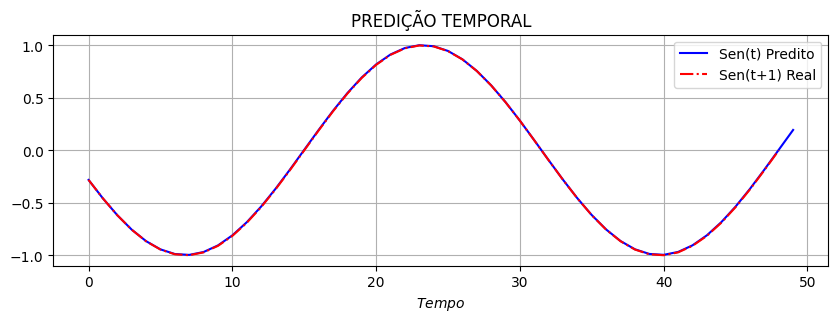

In [375]:
plt.figure(figsize=(10, 3))
plt.title("PREDIÇÃO TEMPORAL")
plt.xlabel("$Tempo$")
plt.plot(Y_pred, label="Sen(t) Predito", color="blue", linestyle="-")
plt.plot(X[51:], label="Sen(t+1) Real", color="red", linestyle="-.")
plt.grid()
plt.legend()
plt.show()

MÉTRICA:

In [376]:
print(Y_pred.shape, Y_test.shape)
R2 = r2_score(Y_pred[:49], Y_test)
print(f"R2: {R2}")

(50, 1) (49, 1)
R2: 0.9999736174371724


# **SOLUÇÃO 2**


CRIAÇÃO DO MODELO:

- Conexão de nós para gerar modelo;

- "*>>*" realiza a conexão dos nós.

In [377]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(100, lr=0.5, sr=0.9)
readout = Ridge(ridge=1e-7)

esn_model = reservoir >> readout

TREINAR A ESN:

In [378]:
esn_model = esn_model.fit(X_train, Y_train, warmup=10)

- Verificar se o método inicializou os nós e treinou o modelo:

In [379]:
print(reservoir.initialized, readout.initialized)

True True


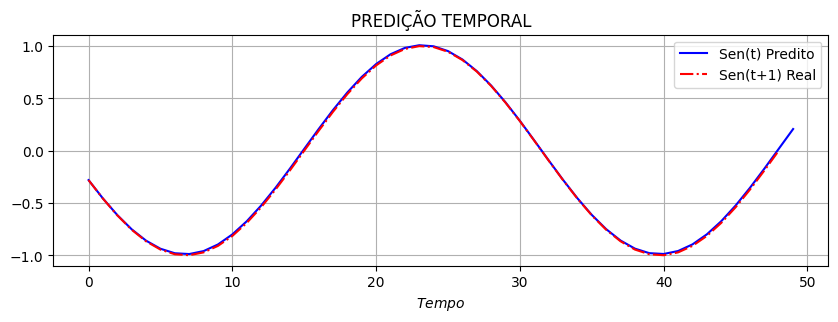

In [380]:
Y_pred = esn_model.run(X_test)
 
plt.figure(figsize=(10, 3))
plt.title("PREDIÇÃO TEMPORAL")
plt.xlabel("$Tempo$")
plt.plot(Y_pred, label="Sen(t) Predito", color="blue", linestyle="-")
plt.plot(X[51:], label="Sen(t+1) Real", color="red", linestyle="-.")
plt.grid()
plt.legend()
plt.show()

MÉTRICA:

In [381]:
print(Y_pred.shape, Y_test.shape)
R2 = r2_score(Y_pred[:49], Y_test)
print(f"R2: {R2}")

(50, 1) (49, 1)
R2: 0.9997085469307123


REFERÊNCIA:
- https://reservoirpy.readthedocs.io/en/latest/user_guide/quickstart.html#Create-the-ESN-model

- https://en.wikibooks.org/wiki/LaTeX/Mathematics

- https://www.ai.rug.nl/minds/uploads/leakyESN.pdf